In [100]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

In [102]:
import pandas as pd
pd.set_option("display.precision", 5)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
data_raw=pd.read_csv("data_v1-14.csv")
data_x = data_raw[data_raw.columns[0:-1]]
data_y = data_raw[data_raw.columns[-1]]
data_x=pd.DataFrame([1 for i in range(len(data_x))]).join(data_x)
random_state=165187


In [103]:
data_raw


,x1,x2,x3,x4,x5,y
0,-2.2260,-3.33850,21.5700,4.6130,2.9476,0.63067
1,-1.8277,-2.16650,8.3625,3.0963,1.3125,0.56830
2,-2.2884,-3.66030,27.5190,5.1227,3.6367,0.48881
3,-2.2080,-3.54230,26.3740,5.0701,3.6670,0.68454
4,-1.8492,-2.38070,13.9400,3.4534,1.8082,0.38109
...,...,...,...,...,...,...
145,1.7988,1.49850,9.7694,2.9744,6.9357,1.59310
146,1.9463,1.27580,14.0110,3.7480,8.3389,1.75100
147,2.1860,0.96062,24.2060,4.8389,10.3600,2.19490
148,1.7909,1.23280,11.2650,3.5103,7.7255,1.78640


In [94]:
def fit_OLS(data_x, data_y, is_print_res=True):
    X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=random_state)
    param_vec=np.matmul(np.matmul(np.linalg.inv(np.matmul(np.array(X_train).T, 
                                                        np.array(X_train))),
                                np.array(X_train).T),
                        np.array(y_train))
    if is_print_res:
        print(f"accuracy on train: {r2_score(y_train, np.matmul(np.array(X_train), param_vec.T))}"+
        f"\naccuracy on test: {r2_score(y_test, np.matmul(np.array(X_test), param_vec.T))}")
    s_e2=sum(((y_train)-np.matmul(X_train, param_vec))**2)/(len(X_train)-len(X_train.iloc[0])-1-1)
    cov_beta=s_e2*np.linalg.inv(np.matmul(np.array(X_train).T, np.array(X_train)))
    characteristic_params=pd.DataFrame( columns=["Value", "Dispersion", "Interval, P=90%", "Interval, P=99%", 
                                                "Z", "Res(signif level=0.1)","Res(signif level=0.01)", "p-value"], 
                                    index=["intercept"] + [f"beta{x[1]}" for x in X_train.columns[1:]])
    stat_des={True: "significant",
            False: "not significant"}
    for i in range(len(X_train.iloc[0])):
        characteristic_params["Value"][i]=param_vec[i]
        characteristic_params["Dispersion"][i]=cov_beta[i][i]
        characteristic_params["Interval, P=90%"][i]=(f"{param_vec[i]-t.isf(0.05, len(y_train)-len(X_train.iloc[0])-1-1)*np.sqrt(cov_beta[i][i]):.3f}", 
                                                    f"{param_vec[i]+t.isf(0.05, len(y_train)-len(X_train.iloc[0])-1-1)*np.sqrt(cov_beta[i][i]):.3f}")
        characteristic_params["Interval, P=99%"][i]=(f"{param_vec[i]-t.isf(0.005, len(y_train)-len(X_train.iloc[0])-1-1)*np.sqrt(cov_beta[i][i]):.3f}", 
                                                    f"{param_vec[i]+t.isf(0.005, len(y_train)-len(X_train.iloc[0])-1-1)*np.sqrt(cov_beta[i][i]):.3f}")
        characteristic_params["Z"][i]=param_vec[i]/np.sqrt(cov_beta[i][i])
        characteristic_params["Res(signif level=0.1)"][i] = stat_des[characteristic_params["Z"][i]>t.isf(0.05, len(y_train)-len(X_train.iloc[0])-1-1) 
                                                                    or characteristic_params["Z"][i]<-t.isf(0.05, len(y_train)-len(X_train.iloc[0])-1-1)]
        characteristic_params["Res(signif level=0.01)"][i] = stat_des[characteristic_params["Z"][i]>t.isf(0.005, len(y_train)-len(X_train.iloc[0])-1-1)
                                                                    or characteristic_params["Z"][i]<-t.isf(0.005, len(y_train)-len(X_train.iloc[0])-1-1)]
        characteristic_params["p-value"][i] = 2*min([t.cdf(characteristic_params["Z"][i], len(y_train)-len(X_train.iloc[0])-1-1), 
                                                    1-t.cdf(characteristic_params["Z"][i], len(y_train)-len(X_train.iloc[0])-1-1)])
    return characteristic_params


Пункт 1

In [104]:
fit_OLS(data_x, data_y)

accuracy on train: 0.953566329136673
accuracy on test: 0.9551716365597259


,Value,Dispersion,"Interval, P=90%","Interval, P=99%",Z,Res(signif level=0.1),Res(signif level=0.01),p-value
intercept,-0.78733,1.62106,"(-2.902, 1.327)","(-4.133, 2.558)",-0.61839,not significant,not significant,0.53777
beta1,-1.05677,3.00712,"(-3.937, 1.823)","(-5.613, 3.500)",-0.6094,not significant,not significant,0.54368
beta2,1.15486,0.99938,"(-0.505, 2.815)","(-1.472, 3.782)",1.15522,not significant,not significant,0.25084
beta3,0.00124,0.00002,"(-0.006, 0.008)","(-0.010, 0.012)",0.29265,not significant,not significant,0.77041
beta4,0.53058,2.22304,"(-1.946, 3.007)","(-3.387, 4.448)",0.35586,not significant,not significant,0.72272
beta5,0.14031,0.84431,"(-1.386, 1.666)","(-2.274, 2.555)",0.1527,not significant,not significant,0.87895


Пункт 2


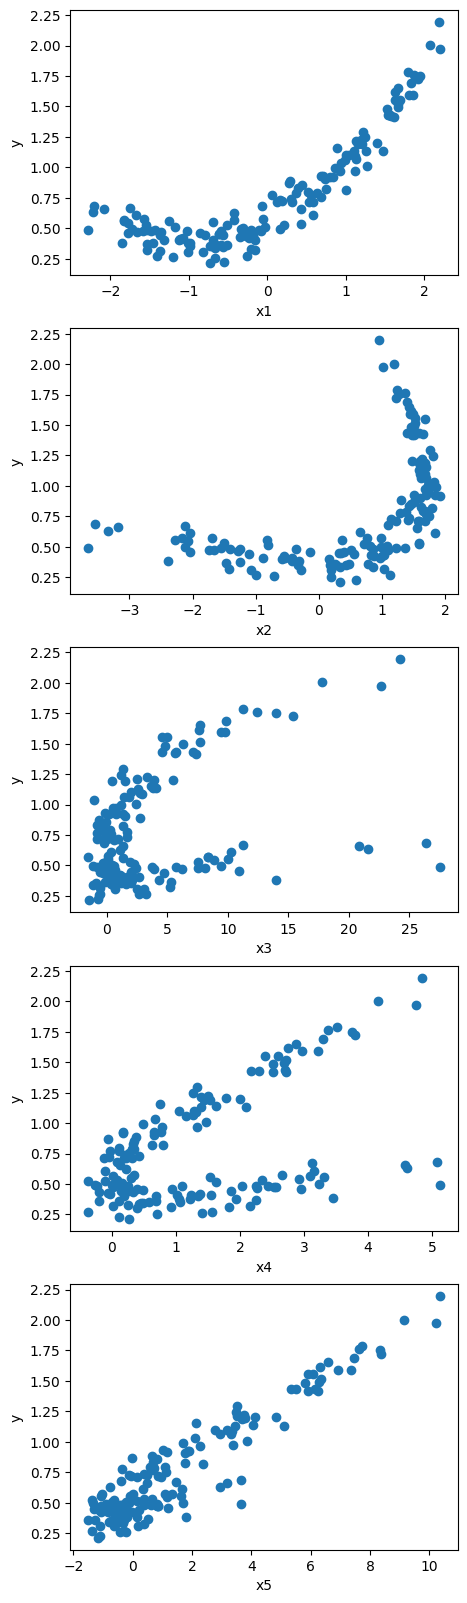

In [88]:
InteractiveShell.ast_node_interactivity="none"
fig, ax=plt.subplots(5,1)
fig.set_size_inches(5,20)
for i in range(5):
    ax[i].scatter(data_x[f"x{i+1}"], data_y)
    ax[i].set_xlabel(f"x{i+1}")
    ax[i].set_ylabel("y")
InteractiveShell.ast_node_interactivity="all"

In [105]:
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=random_state)
corr=X_train[X_train.columns[1:]].join(y_train).corr()
multi_corr=pd.DataFrame([1-np.linalg.det(corr)/np.linalg.det(corr.drop(col).drop(col, axis=1)) for col in corr.columns],
                        index=[col for col in corr.columns], columns=["multiple corr"])
corr=corr.join(multi_corr)
corr.style.background_gradient(cmap="coolwarm")

,x1,x2,x3,x4,x5,y,multiple corr
x1,1.000000,0.875239,-0.075963,-0.077610,0.646436,0.824811,0.999978
x2,0.875239,1.000000,-0.512782,-0.550110,0.196790,0.469572,0.999954
x3,-0.075963,-0.512782,1.000000,0.925207,0.654293,0.419881,0.859278
x4,-0.077610,-0.550110,0.925207,1.000000,0.710487,0.456507,0.999978
x5,0.646436,0.196790,0.654293,0.710487,1.000000,0.931542,0.999985
y,0.824811,0.469572,0.419881,0.456507,0.931542,1.000000,0.953566


Пункт 3

In [106]:
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=random_state)
cond_numb=np.linalg.cond(np.matmul(np.array(X_train).T, np.array(X_train)))
print(f"condition number = {cond_numb}")

condition number = 3353660.8000215767


In [107]:
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=random_state)
data_x_upd=data_x.copy()
vif=pd.DataFrame([variance_inflation_factor(X_train[X_train.columns[1:]], i) 
                          for i in range(0, len(X_train.columns)-1)], index=X_train.columns[1:], 
                          columns=["vif"])
vif.T
while max(vif["vif"])>=5:
    data_x_upd=data_x_upd.drop(vif.loc[vif["vif"]==max(vif["vif"])].index[0], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(data_x_upd, data_y, test_size=0.3, random_state=random_state)
    vif=pd.DataFrame([variance_inflation_factor(X_train[X_train.columns[1:]], i) 
                            for i in range(0, len(X_train.columns)-1)], index=X_train.columns[1:], 
                          columns=["vif"])
    vif.T

corr=X_train[X_train.columns[1:]].join(y_train).corr()
multi_corr=pd.DataFrame([1-np.linalg.det(corr)/np.linalg.det(corr.drop(col).drop(col, axis=1)) for col in corr.columns],
                        index=[col for col in corr.columns], columns=["multiple corr"])
corr=corr.join(multi_corr)
corr.style.background_gradient(cmap="coolwarm")

,x1,x2,x3,x4,x5
vif,42990.54242,1921.1565,10.04973,54153.60058,73809.43937


,x1,x2,x3,x4
vif,3.34722,3.66759,9.92538,9.31017


,x1,x2,x4
vif,2.84319,2.89043,1.04022


,x1,x2,x4,y,multiple corr
x1,1.000000,0.875239,-0.077610,0.824811,0.999933
x2,0.875239,1.000000,-0.550110,0.469572,0.999953
x4,-0.077610,-0.550110,1.000000,0.456507,0.999803
y,0.824811,0.469572,0.456507,1.000000,0.953517


Пункт 4


In [97]:
fit_OLS(data_x_upd, data_y)

accuracy on train: 0.953517060224048
accuracy on test: 0.9545038052449427


,Value,Dispersion,"Interval, P=90%","Interval, P=99%",Z,Res(signif level=0.1),Res(signif level=0.01),p-value
intercept,-0.81201,1.38614,"(-2.767, 1.143)","(-3.904, 2.280)",-0.68969,not significant,not significant,0.492
beta1,-0.80422,0.9606,"(-2.432, 0.823)","(-3.378, 1.770)",-0.82055,not significant,not significant,0.41388
beta2,1.12686,0.96153,"(-0.501, 2.755)","(-1.449, 3.702)",1.14918,not significant,not significant,0.25325
beta4,0.73207,0.24064,"(-0.082, 1.547)","(-0.556, 2.020)",1.49234,not significant,not significant,0.13879


Пункт 5


In [98]:
#Исключаем регрессоры, у которых наименьшее значение Z
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=random_state)
data_x_upd=data_x.copy()
vif=pd.DataFrame([variance_inflation_factor(X_train[X_train.columns[1:]], i) 
                          for i in range(0, len(X_train.columns)-1)], index=X_train.columns[1:], 
                          columns=["vif"])
vif.T
while max(vif["vif"])>=5:
    characteristic_params=fit_OLS(data_x_upd, data_y, False)
    ind_num=characteristic_params["Z"].loc[abs(characteristic_params["Z"])==min(abs(characteristic_params["Z"][1:]))].index[0][-1]
    characteristic_params=characteristic_params.drop(f"beta{ind_num}")
    data_x_upd=data_x_upd.drop(f"x{ind_num}", axis=1)
    X_train, X_test, y_train, y_test = train_test_split(data_x_upd, data_y, test_size=0.3, random_state=random_state)
    vif=pd.DataFrame([variance_inflation_factor(X_train[X_train.columns[1:]], i) 
                            for i in range(0, len(X_train.columns)-1)], index=X_train.columns[1:], 
                          columns=["vif"])
    vif.T

corr=X_train[X_train.columns[1:]].join(y_train).corr()
multi_corr=pd.DataFrame([1-np.linalg.det(corr)/np.linalg.det(corr.drop(col).drop(col, axis=1)) for col in corr.columns],
                        index=[col for col in corr.columns], columns=["multiple corr"])
corr=corr.join(multi_corr)
corr.style.background_gradient(cmap="coolwarm")

fit_OLS(data_x_upd, data_y)

,x1,x2,x3,x4,x5
vif,42990.54242,1921.1565,10.04973,54153.60058,73809.43937


,x1,x2,x3,x4
vif,3.34722,3.66759,9.92538,9.31017


,x1,x2,x4
vif,2.84319,2.89043,1.04022


,x1,x2,x4,y,multiple corr
x1,1.000000,0.875239,-0.077610,0.824811,0.999933
x2,0.875239,1.000000,-0.550110,0.469572,0.999953
x4,-0.077610,-0.550110,1.000000,0.456507,0.999803
y,0.824811,0.469572,0.456507,1.000000,0.953517


accuracy on train: 0.953517060224048
accuracy on test: 0.9545038052449427


,Value,Dispersion,"Interval, P=90%","Interval, P=99%",Z,Res(signif level=0.1),Res(signif level=0.01),p-value
intercept,-0.81201,1.38614,"(-2.767, 1.143)","(-3.904, 2.280)",-0.68969,not significant,not significant,0.492
beta1,-0.80422,0.9606,"(-2.432, 0.823)","(-3.378, 1.770)",-0.82055,not significant,not significant,0.41388
beta2,1.12686,0.96153,"(-0.501, 2.755)","(-1.449, 3.702)",1.14918,not significant,not significant,0.25325
beta4,0.73207,0.24064,"(-0.082, 1.547)","(-0.556, 2.020)",1.49234,not significant,not significant,0.13879


In [99]:
#Исключаем регрессоры, у которых наименьшее значение VIF
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=random_state)
data_x_upd=data_x.copy()
vif=pd.DataFrame([variance_inflation_factor(X_train[X_train.columns[1:]], i) 
                          for i in range(0, len(X_train.columns)-1)], index=X_train.columns[1:], 
                          columns=["vif"])
vif.T
while max(vif["vif"])>=5:
    data_x_upd=data_x_upd.drop(vif.loc[vif["vif"]==min(vif["vif"])].index[0], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(data_x_upd, data_y, test_size=0.3, random_state=random_state)
    vif=pd.DataFrame([variance_inflation_factor(X_train[X_train.columns[1:]], i) 
                            for i in range(0, len(X_train.columns)-1)], index=X_train.columns[1:], 
                          columns=["vif"])
    vif.T

corr=X_train[X_train.columns[1:]].join(y_train).corr()
multi_corr=pd.DataFrame([1-np.linalg.det(corr)/np.linalg.det(corr.drop(col).drop(col, axis=1)) for col in corr.columns],
                        index=[col for col in corr.columns], columns=["multiple corr"])
corr=corr.join(multi_corr)
corr.style.background_gradient(cmap="coolwarm")

fit_OLS(data_x_upd, data_y)

              x1         x2        x3           x4           x5
vif  42990.54242  1921.1565  10.04973  54153.60058  73809.43937

              x1          x2           x4           x5
vif  42425.60948  1888.12861  53327.54825  72896.17631

           x1      x4        x5
vif  46.05513  85.042  111.5926

          x4       x5
vif  2.47883  2.47883



,x4,x5,y,multiple corr
x4,1.000000,0.710487,0.456507,0.823669
x5,0.710487,1.000000,0.931542,0.970546
y,0.456507,0.931542,1.000000,0.952916


accuracy on train: 0.9529164028933784
accuracy on test: 0.9553746229462633


,Value,Dispersion,"Interval, P=90%","Interval, P=99%",Z,Res(signif level=0.1),Res(signif level=0.01),p-value
intercept,0.62151,0.00018,"(0.599, 0.644)","(0.586, 0.657)",45.69465,significant,significant,0.0
beta4,-0.13334,0.0001,"(-0.150, -0.117)","(-0.159, -0.107)",-13.44768,significant,significant,0.0
beta5,0.2012,0.00003,"(0.193, 0.210)","(0.188, 0.214)",39.76515,significant,significant,0.0
